In [ ]:
# Trained Brackish Dataset_(Split Ratio__Train= 11739, Test= 1467, Validation= 1468),  HpTn_Accuracy= 78.77% /  

# Data Augmentation ()

# N/A Regularization Elastic_Net (L1=0.0, L2=0.0)            [L1= Lasso Regression, L2= Riedge regression]

# Convolution_Layers Conv2D_( 328 --> 204 --> 248 --> 432 -->)         [Formation of Conv2D layers ]

# N/A Batch Normalization Conv2D_( /--> /--> /--> /--> /)    [ '/' it represents the application of Batch-Normalization]

# Dense_Layers ( 464 --> 176 --> 112 --> )          [Formation of Dense layers ]

# Dropout_Rate ( 464/0.1 , /0.0 , /0.0 )        ['/' it represents Dense_Layers  where Dropout rate Present]

# optimizers= Relu , Adam

# Learning_rate= 0.0003102 

# Input Shape= 224 , 224

# Batch-size= 64

# Padding= Same

# Strides= 1

# Epoch-size= 10/20/

In [2]:
# Imorting Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,BatchNormalization,Dropout #Adding Batch Normalization & Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

import keras_tuner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# loading Dataset Labels
train_labels = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train/_annotations.csv')
test_labels = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test/_annotations.csv')
valid_labels = pd.read_csv('/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid/_annotations.csv')

In [4]:
# Specify target Image_size
image_width=180
image_height=180
batch_size=64

In [5]:
# Rescalling (Images )
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Converting Image to Array, Array to Image & Image Data Loading
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/train', # Specify the directory containing training images
    x_col='filename',                 # Name of the column containing filenames
    y_col='class',                                                                        # Name of the column containing labels
    target_size=(image_width, image_height),    # Resize images to the desired dimensions
    batch_size=batch_size,
    class_mode='categorical'               # Number of Classes in this case 'catagorical' means its detects  classes automatically
)

Found 28518 validated image filenames belonging to 6 classes.


In [7]:
# Image Data Loading from Test path
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_labels,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/test',
    x_col='filename',
    y_col='class',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3466 validated image filenames belonging to 6 classes.


In [8]:
# Image Data Loading from Valid path
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_labels,
    directory='/kaggle/input/brackish-tf/Brackish 960x540.tensorflow/valid',
    x_col='filename',
    y_col='class',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3581 validated image filenames belonging to 6 classes.


In [9]:
# Define CNN Architecture (Brackish 5T_HpTn Weights)

model = Sequential([

    Conv2D(140, (3, 3), activation='relu', strides=1, padding='same', input_shape=(180, 180, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(124, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(44, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(380, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(460, activation='relu'),
    (Dropout(0.2)),

    Dense(56, activation='relu'),

    Dense(188, activation='relu'),

# Output layer with softmax activation for classification

    Dense(6, activation='softmax') 
])


learning_rate = 0.0003102     #  We Can Adjust this value for Adam Learning rate
optimizer = Adam(learning_rate=learning_rate)

# Define custom F1 score metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 140)  │         3,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 140)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 124)    │       156,364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 124)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 42, 42, 44)     │        49,148 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 44)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 380)    │       150,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 380)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30780)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 460)            │    14,159,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 460)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 56)             │        25,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 188)            │        10,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,557,218 (55.53 MB)

 Trainable params: 14,557,218 (55.53 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile the model with additional metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(), Recall(), F1Score()])

In [12]:
#Training of Model (takes 3.5 hours )
history = model.fit(train_generator, epochs=10, validation_data=valid_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718139536.823842     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718139536.847615     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/446 ━━━━━━━━━━━━━━━━━━━━ 3:01 596ms/step - accuracy: 0.3350 - f1_score: 0.0189 - loss: 1.5020 - precision: 0.3492 - recall: 0.0098

W0000 00:00:1718139621.000190     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/446 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.4290 - f1_score: 0.2014 - loss: 1.3436 - precision: 0.5505 - recall: 0.1335

W0000 00:00:1718139714.079586     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/446 ━━━━━━━━━━━━━━━━━━━━ 249s 467ms/step - accuracy: 0.4293 - f1_score: 0.2019 - loss: 1.3431 - precision: 0.5508 - recall: 0.1339 - val_accuracy: 0.7241 - val_f1_score: 0.7231 - val_loss: 0.7022 - val_precision: 0.7806 - val_recall: 0.6736
Epoch 2/10


W0000 00:00:1718139744.952143     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


446/446 ━━━━━━━━━━━━━━━━━━━━ 111s 245ms/step - accuracy: 0.7312 - f1_score: 0.7206 - loss: 0.6837 - precision: 0.7733 - recall: 0.6748 - val_accuracy: 0.7584 - val_f1_score: 0.7590 - val_loss: 0.5751 - val_precision: 0.7884 - val_recall: 0.7316
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 108s 238ms/step - accuracy: 0.7579 - f1_score: 0.7510 - loss: 0.5825 - precision: 0.7888 - recall: 0.7168 - val_accuracy: 0.7777 - val_f1_score: 0.7717 - val_loss: 0.5287 - val_precision: 0.8045 - val_recall: 0.7414
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 110s 242ms/step - accuracy: 0.7705 - f1_score: 0.7676 - loss: 0.5417 - precision: 0.7998 - recall: 0.7379 - val_accuracy: 0.7822 - val_f1_score: 0.7767 - val_loss: 0.5078 - val_precision: 0.8095 - val_recall: 0.7464
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 110s 243ms/step - accuracy: 0.7726 - f1_score: 0.7697 - loss: 0.5200 - precision: 0.8004 - recall: 0.7413 - val_accuracy: 0.7811 - val_f1_score: 0.7799 - val_loss: 0.4971 - val_precision: 0.8081 - val_re

In [13]:
# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(valid_generator)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1_score}")

56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.7970 - f1_score: 0.7953 - loss: 0.4675 - precision: 0.8145 - recall: 0.7771
Test Accuracy: 0.7891650199890137
Test Precision: 0.8070175647735596
Test Recall: 0.770734429359436
Test F1 Score: 0.7884587645530701


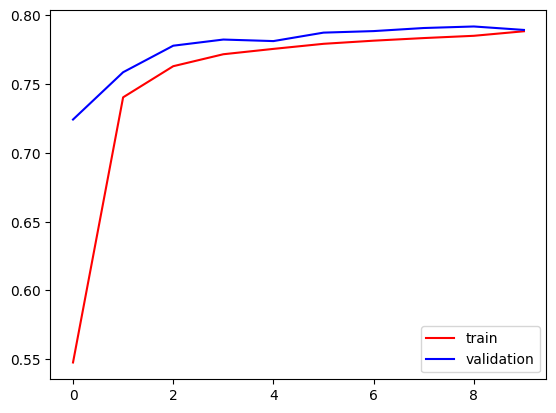

In [14]:
# Ploting Accuracy Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

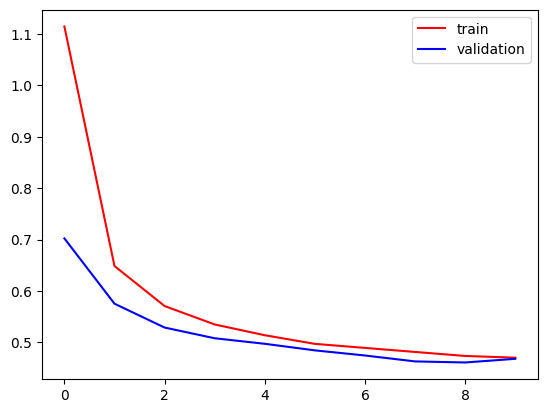

In [15]:
# Ploting Loss Graph
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

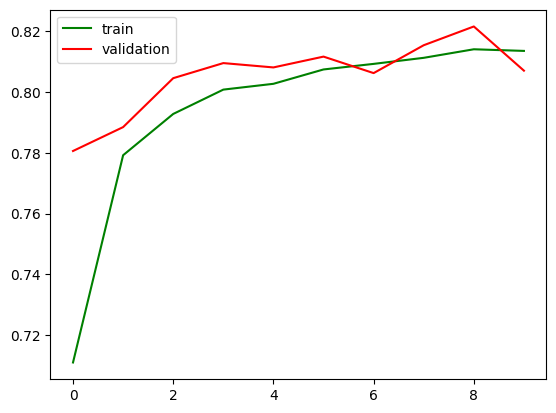

In [16]:
# Ploting Precision Graph
plt.plot(history.history['precision'],color='Green',label='train')
plt.plot(history.history['val_precision'],color='red',label='validation')
plt.legend()
plt.show()

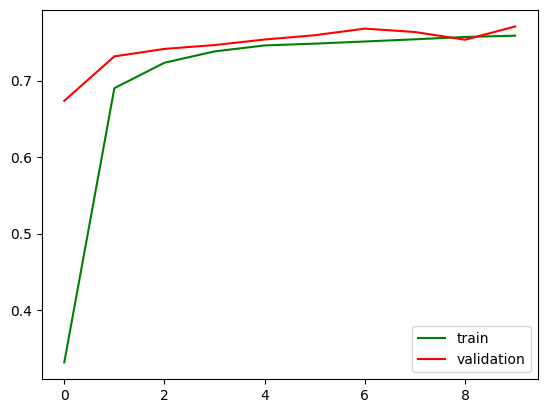

In [17]:
# Ploting Recall Graph
plt.plot(history.history['recall'],color='Green',label='train')
plt.plot(history.history['val_recall'],color='red',label='validation')
plt.legend()
plt.show()

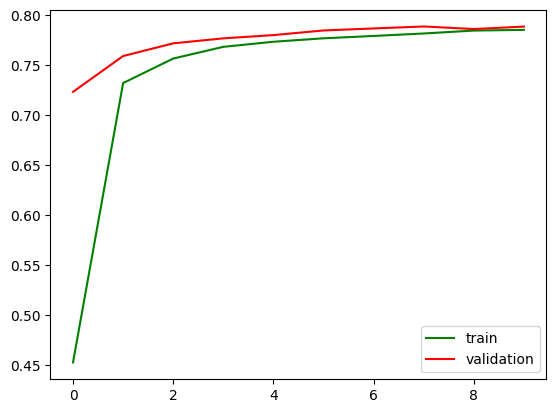

In [18]:
# Ploting F1 Score Graph
plt.plot(history.history['f1_score'],color='Green',label='train')
plt.plot(history.history['val_f1_score'],color='red',label='validation')
plt.legend()
plt.show()

In [19]:
#Saving the Model
model.save('5T_Brackish(78.91%).h5')

In [ ]:
#Training of Model (takes 3.5 hours )
history = model.fit(train_generator, epochs=20, validation_data=valid_generator)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(valid_generator)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Ploting Accuracy Graph

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
# Ploting Loss Graph
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
#Saving the Model
model.save('5T_Brackish(79.47%).h5')